In [1]:
!pip install -q efficientnet

In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
os.listdir("/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease")

Using TensorFlow backend.


['Original Dataset']

In [3]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((75,75))
image_size = 0
directory_root = '/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease'
width=75
height=75
depth=3

In [81]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list, directory_list = [], [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True:
                    directory_list.append(image_directory)
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                else:
                    print(image_directory)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Downy Mildew ...
[INFO] Processing Black Rot ...
[INFO] Processing Bacterial spot rot ...
[INFO] Processing No disease ...
[INFO] Image loading completed


In [78]:
for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']

In [40]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Bacterial spot rot' 'Black Rot' 'Downy Mildew' 'No disease']


In [41]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.1, random_state = 42) 

[INFO] Spliting data to train, test


In [42]:
x_train.shape,x_test.shape

((590, 75, 75, 3), (66, 75, 75, 3))

In [43]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [44]:
import tensorflow as tf
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     min_delta=0.0001,
                                     patience=10,
                                     mode="auto",
                                     verbose = 1)
]

In [45]:
len(image_list)

656

# **Our Model**

In [46]:
def Res_Plot_Test_Save(name):
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    print("[INFO] Saving model")
    model.save(name)

In [47]:
def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [48]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [97]:
# def create_model():
model = tf.keras.backend.clear_session()
model = None
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution

# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy', f1_m,  precision_m, recall_m])


In [98]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 64)       

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [99]:
# train the network
print("[INFO] training network...")
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100
    )

[INFO] training network...
Epoch 1/100
18/18 [==============================] - 3s 160ms/step - loss: 0.7196 - accuracy: 0.7643 - f1_m: 0.5032 - precision_m: 0.5253 - recall_m: 0.4839 - val_loss: 0.5298 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 49ms/step - loss: 0.4853 - accuracy: 0.8396 - f1_m: 0.6646 - precision_m: 0.6850 - recall_m: 0.6458 - val_loss: 0.5465 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 1s 72ms/step - loss: 0.3528 - accuracy: 0.8808 - f1_m: 0.7470 - precision_m: 0.7628 - recall_m: 0.7321 - val_loss: 0.5575 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 1s 62ms/step - loss: 0.2861 - accuracy: 0.8916 - f1_m: 0.7840 - precision_m: 0.7896 -

In [100]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

In [101]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.9621211886405945 
Loss:0.11843341295466536 
F1_score: 0.9479166865348816 
Precision: 0.9479166865348816 
Recall: 0.9479166865348816


## Predicting on a single image

/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease/Original Dataset/Black Rot/Black Rot(34).jpg


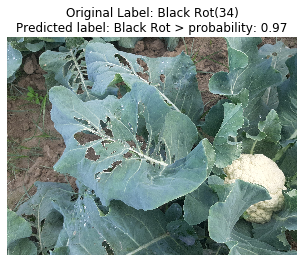

In [167]:
from random import randint

image_dir= "/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease/Original Dataset/Black Rot/Black Rot(34).jpg"
print(image_dir)
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
# print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()

## Predicting on four random images

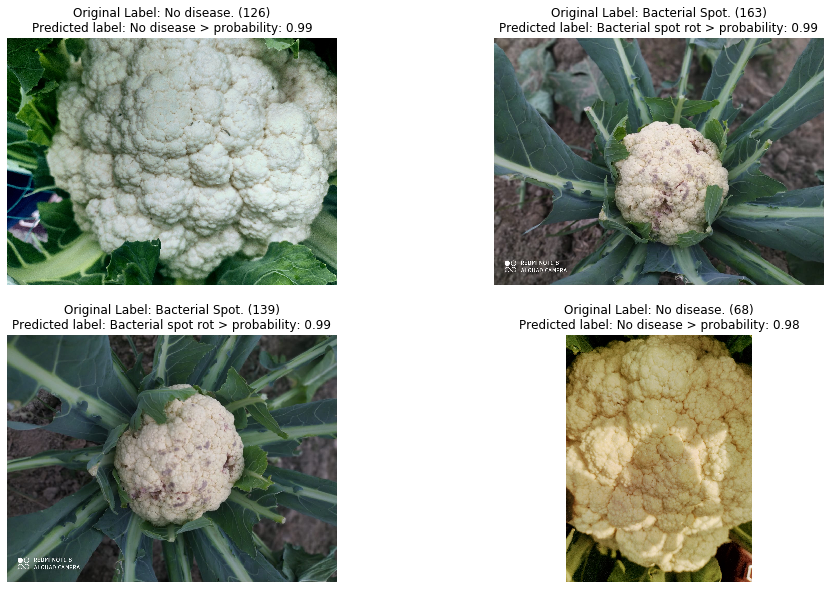

In [168]:
# create figure
fig = plt.figure(figsize=(16, 10))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image2 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image2)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image3 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image3)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image4 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image4)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()

In [29]:
Res_Plot_Test_Save('penta_CNN_Algorithm.h5')

[INFO] Calculating model accuracy
55/55 [==============================] - 0s 304us/step
Test Accuracy: 81.81818127632141
[INFO] Saving model


# **Inception**

In [58]:
model = tf.keras.backend.clear_session()

In [59]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
# model = tf.keras.backend.clear_session()


# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=inputShape)
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m]) 
# model.summary()

87916544/87910968 [==============================] - 7s 0us/step


In [60]:
# train the network
print("[INFO] training INCEPTION network...")
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100
    )

[INFO] training INCEPTION network...
Epoch 1/100
18/18 [==============================] - 8s 437ms/step - loss: 0.5546 - accuracy: 0.7496 - f1_m: 0.1558 - precision_m: 0.5581 - recall_m: 0.0987 - val_loss: 0.6493 - val_accuracy: 0.7083 - val_f1_m: 0.2013 - val_precision_m: 0.2540 - val_recall_m: 0.1667
Epoch 2/100
18/18 [==============================] - 1s 56ms/step - loss: 0.4944 - accuracy: 0.7832 - f1_m: 0.3753 - precision_m: 0.6545 - recall_m: 0.2666 - val_loss: 0.7335 - val_accuracy: 0.6932 - val_f1_m: 0.1732 - val_precision_m: 0.2138 - val_recall_m: 0.1458
Epoch 3/100
18/18 [==============================] - 1s 67ms/step - loss: 0.4296 - accuracy: 0.8105 - f1_m: 0.5123 - precision_m: 0.6959 - recall_m: 0.4082 - val_loss: 0.6774 - val_accuracy: 0.7727 - val_f1_m: 0.4899 - val_precision_m: 0.5436 - val_recall_m: 0.4543
Epoch 4/100
18/18 [==============================] - 1s 52ms/step - loss: 0.4266 - accuracy: 0.8132 - f1_m: 0.5503 - precision_m: 0.7009 - recall_m: 0.4571 - val_lo

In [104]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

In [61]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.8636363744735718 
Loss:0.7115573379578013 
F1_score: 0.8125 
Precision: 0.8125 
Recall: 0.8125


In [62]:
Res_Plot_Test_Save('Inception_ModelV3_(Imagenet_Weights).h5')

[INFO] Calculating model accuracy
66/66 [==============================] - 0s 1ms/step
Test Accuracy: 86.36363744735718
[INFO] Saving model


# **Resnet Model**

In [63]:
from keras.models import Model
from keras import applications
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
model = tf.keras.backend.clear_session()

# Get the Resnet model so we can do transfer learning
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (75,75,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m]) 
# model.summary()

In [64]:
# train the network
print("[INFO] training RESNET network...")
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100
    )

[INFO] training RESNET network...
Epoch 1/100
18/18 [==============================] - 26s 1s/step - loss: 1.1826 - accuracy: 0.7061 - f1_m: 0.1483 - precision_m: 0.2803 - recall_m: 0.1285 - val_loss: 6.2743 - val_accuracy: 0.5909 - val_f1_m: 0.2812 - val_precision_m: 0.2812 - val_recall_m: 0.2812
Epoch 2/100
18/18 [==============================] - 3s 149ms/step - loss: 0.6490 - accuracy: 0.7527 - f1_m: 0.0692 - precision_m: 0.5926 - recall_m: 0.0370 - val_loss: 6.2743 - val_accuracy: 0.5909 - val_f1_m: 0.2812 - val_precision_m: 0.2812 - val_recall_m: 0.2812
Epoch 3/100
18/18 [==============================] - 2s 129ms/step - loss: 0.6866 - accuracy: 0.7446 - f1_m: 0.0399 - precision_m: 0.2870 - recall_m: 0.0218 - val_loss: 4.8800 - val_accuracy: 0.6818 - val_f1_m: 0.4062 - val_precision_m: 0.4062 - val_recall_m: 0.4062
Epoch 4/100
18/18 [==============================] - 2s 123ms/step - loss: 0.5546 - accuracy: 0.7531 - f1_m: 0.0882 - precision_m: 0.3864 - recall_m: 0.0573 - val_loss

In [65]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

In [66]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.8030303120613098 
Loss:0.6712760067347324 
F1_score: 0.572916567325592 
Precision: 0.5729166865348816 
Recall: 0.5729166865348816


In [67]:
Res_Plot_Test_Save('ResNet_(Imagenet_Weights).h5')

[INFO] Calculating model accuracy
66/66 [==============================] - 0s 1ms/step
Test Accuracy: 80.30303120613098
[INFO] Saving model


# **VGG16 Model**

In [68]:
tf.keras.backend.clear_session()
model = None
model

In [69]:
from keras.models import Model
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
model = tf.keras.backend.clear_session()
# Get the Resnet model so we can do transfer learning
base_model = vgg16.VGG16(weights= None, include_top=False, input_shape= (75,75,3))
# model= None                          
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m]) 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

In [70]:
# train the network
print("[INFO] training VGG16 network...")
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100
    )

[INFO] training VGG16 network...
Epoch 1/100
18/18 [==============================] - 3s 147ms/step - loss: 0.7388 - accuracy: 0.7357 - f1_m: 0.0162 - precision_m: 0.0208 - recall_m: 0.0139 - val_loss: 0.5591 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 1s 71ms/step - loss: 0.5551 - accuracy: 0.7500 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.5572 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 1s 79ms/step - loss: 0.5513 - accuracy: 0.7500 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.5587 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 1s 58ms/step - loss: 0.5529 - accuracy: 0.7500 - f1_m: 

In [74]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

In [75]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.75 
Loss:0.5629188436450381 
F1_score: 0.0 
Precision: 0.0 
Recall: 0.0


In [76]:
Res_Plot_Test_Save('VGG16_(Imagenet_Weights).h5')

[INFO] Calculating model accuracy
66/66 [==============================] - 0s 617us/step
Test Accuracy: 75.0
[INFO] Saving model
